# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# ⚽ Methodlogy
* In this notebook I'll demonstrate how to train **Unet** model using PyTorch.
* For mask I'll be using pre-computed mask from [here](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)
* As there are overlaps between **Stomach**, **Large Bowel** & **Small Bowel** classes, this is a **MultiLabel Segmentation** task, so final activaion should be `sigmoid` instead of `softmax`.
* For data split I'll be using **StratifiedGroupFold** to avoid data leakage due to `case` and to stratify `empty` and `non-empty` mask cases.
* You can play with different models and losses.

## sources

 Awsaf's UWMGI

📌 **Data/Dataset**:
* Data: [UWMGI: Mask Data](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-data)
* Dataset: [UWMGI: Mask Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-mask-dataset)

📌 **UNet**:
* Train: [UWMGI: Unet [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/)

# 🛠 Install Libraries

In [3]:
import pandas as pd
df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/train.csv')


38496.0

In [5]:
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [6]:
df=df.drop(columns=['class','segmentation']).drop_duplicates()

In [7]:
df.head()

,id
0,case123_day20_slice_0001
3,case123_day20_slice_0002
6,case123_day20_slice_0003
9,case123_day20_slice_0004
12,case123_day20_slice_0005


In [4]:
len(df)

115488

In [8]:
len(df)

38496

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/open_directory/test/IMAGE')
!pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/18A-45l2iGPLTzGSEx1Bd0wrE_qi8y2Ai/open_directory/test/IMAGE


In [2]:
!pip install timm
!pip install -q segmentation_models_pytorch
!pip install -q scikit-learn==1.0
!pip install albumentations==0.4.6
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install qudida
!pip install rasterio
!pip install colorama
!pip install torch==1.11.0
!pip install torch_optimizer

!pip install ttach
!pip install opencv-python
!pip install cv2.gapi_wip_gst_GStreamerPipeline
!pip3 install opencv-contrib-python==4.5.5.62

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 13.8 MB/s 
     |████████████████████████████████| 88 kB 1.7 MB/s 
     |████████████████████████████████| 376 kB 38.1 MB/s 
     |████████████████████████████████| 58 kB 4.4 MB/s 
     |████████████████████████████████| 23.1 MB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 14.7 MB/s 
     |████████████████████████████████| 948 kB 64.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=8f80392e977cb31aac5cd0233cd590e6b64aaf8b9b2aad3af488e79c506ecc69
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling

# 📚 Import Libraries 

In [ ]:
'''# 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload하라는 의미. 환경이 코랩이라 사용할 필요 없음.
%load_ext autoreload
%autoreload 2'''

'# 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload하라는 의미. 환경이 코랩이라 사용할 필요 없음.\n%load_ext autoreload\n%autoreload 2'

In [ ]:
import tensorflow as tf
import numpy as np
import cupy as cp
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
# import torch.optim as optim   # Adam 쓰려면
import torch_optimizer as optim # RAdam 쓸거라면
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
import ttach as tta
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
torch.__version__

'1.11.0+cu102'

In [ ]:
ls

0714e16test              dataset_3d_fold_2.json  save_weights/
3d_data/                 dataset_3d_fold_3.json  submission.csv
all_train_images.pickle  dataset_3d_fold_4.json  train1.csv
best_epoch-00.bin        image_pj/               train.csv
data_3d_info.csv         kaggle.json             uwmgi-mask-dataset.zip
dataset/                 last_epoch-00.bin       wandb/
dataset_3d_fold_0.json   nununu.csv              x_trainSample2000.pickle
dataset_3d_fold_1.json   output/                 y_trainSample2000.pickle


# ⚙️ Configuration 

In [ ]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b1-224x224-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    train_bs      = 128  # 128이나 64
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 10 # 원래 15였는데 램 나가버려서 조정
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    thr           = 0.45
    ttas          = [0]

# ❗ Reproducibility

In [ ]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Meta Data

* Files
    * train.csv - IDs and masks for all training objects.
    * sample_submission.csv - a sample submission file in the correct format
    * train - a folder of case/day folders, each containing slice images for a particular case on a given day.

> Note that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * id - unique identifier for object
    * class - the predicted class for the object
    * EncodedPixels - RLE-encoded pixels for the identified object

In [ ]:
# how to make npy files? => uwmgi-mask-data.ipynb ( 266,266,3 -> 160, 192)

In [ ]:
df = pd.read_csv('train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df['image_path'] = df['image_path'].str.replace('/kaggle/input/','./dataset/')
df['mask_path'] = df['mask_path'].str.replace('/kaggle/input/','./dataset/')
df.head()

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
   

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/np/uw-madison-gi-...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/np/uw-madison-gi-...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/np/uw-madison-gi-...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/np/uw-madison-gi-...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,./dataset/uwmgi-mask-dataset/np/uw-madison-gi-...,"[, , ]",0,True


In [ ]:
df['empty'].value_counts() 

True     21906
False    16590
Name: empty, dtype: int64

# 🔨 Utility

In [ ]:
# metadata csv파일에서 정보 가져오기

def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
#     row['id'] = f'case{case}_day{day}_slice_{slice_}'
    return row

## Mask

In [ ]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)  # cp교체
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = cp.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

## Image

In [ ]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)# 이미지파일을 alpha channel까지 포함하여 읽어 들입니다. 안바꾸고 그대로 읽어옴
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb img를 [1, 1, 3]배열 모양으로 반복해 쌓는다. # cp교체 
    img = img.astype('float32') # original is uint16
    mx = np.max(img)# cp교체
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)# cp교체
    msk = msk.astype('float32')
    msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # 이미지 히스토그램균일화 작업. 작은 타일로 쪼개서 타일 별로 밝기 등을 균일화해 뚜렷한 이미지로 만든다.https://m.blog.naver.com/samsjang/220543360864
    # img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

## RLE

길이 부호화 AAAAAAABBBCDD —> A7B3C1D2.

무손실 데이터 압축 알고리즘

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):# 압축해제(복호화)
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]# cp교체
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)# cp교체
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):  # 무손실 압축(부호화) 
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])# cp교체
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1# cp교체
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 📁 Create Folds

In [ ]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3257
      True     4551
1.0   False    3540
      True     4540
2.0   False    3053
      True     3923
3.0   False    3407
      True     4801
4.0   False    3333
      True     4091
Name: id, dtype: int64

# 🍚 Dataset

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))# cp교체
            msk = np.transpose(msk, (2, 0, 1))# cp교체
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))# cp교체
            return torch.tensor(img)

# 🌈 Augmentations

훈련용 데이터를 증가시키는 작업

In [ ]:
# train
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0), # 그리드 왜곡
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0) # 울렁울렁한 효과를 줘서 탄력적으로 변환시키는 것. alpha: 이미지를 흩는다 alpha_affine, sigma: 이미지를 살짝 회전, 늘임
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),  # 중간중간 구멍 뚫어서 다른 이미지 처럼 보이게한다.
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [ ]:
'''
# infer
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}
'''

'\n# infer\ndata_transforms = {\n    "train": A.Compose([\n        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),\n        A.HorizontalFlip(p=0.5),\n        A.VerticalFlip(p=0.5),\n#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),\n        A.OneOf([\n            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),\n# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),\n            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)\n        ], p=0.25),\n#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,\n#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),\n        ], p=1.0),\n    \n    "valid": A.Compose([\n        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),\n        ], p=1.0)\n}\n'

In [ ]:
'''
# 다른 방식으로도 이미지 변형 자유롭게.
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.OneOf([
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                ], p=0.2),

        ], p=1.0),
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}
'''

'\n# 다른 방식으로도 이미지 변형 자유롭게.\ndata_transforms = {\n    "train": A.Compose([\n        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),\n        A.HorizontalFlip(),\n        A.VerticalFlip(),\n        A.OneOf([\n                A.RandomContrast(),\n                A.RandomGamma(),\n                A.RandomBrightness(),\n                ], p=0.2),\n\n        ], p=1.0),\n    "valid": A.Compose([\n        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),\n        ], p=1.0)\n}\n'

In [ ]:
data_transforms

{'train': Compose([
   Resize(always_apply=False, p=1, height=224, width=224, interpolation=0),
   HorizontalFlip(always_apply=False, p=0.5),
   VerticalFlip(always_apply=False, p=0.5),
   ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.050000000000000044, 0.050000000000000044), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
   OneOf([
     GridDistortion(always_apply=False, p=1.0, num_steps=5, distort_limit=(-0.05, 0.05), interpolation=1, border_mode=4, value=None, mask_value=None),
     ElasticTransform(always_apply=False, p=1.0, alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, approximate=False, same_dxdy=False),
   ], p=0.25),
   CoarseDropout(always_apply=False, p=0.5, max_holes=8, max_height=11, max_width=11, min_holes=5, min_height=11, min_width=11, fill_value=0, mask_fill_value=0),
 ], p

# 🍰 DataLoader

In [ ]:
# 연습용으로 아주 적은양만 sampling 했더니 학습은 넘어가는데 마지막 pred 부분에서 마스크된 파일이 보이지 않는다.->에폭 늘리니 해결. 학습량 부족이 원인
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train']) # 데이터셋에서 훈련용 데이터를 증가시킨 다음
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True) # false = full training

In [ ]:
# TypeError: Caught TypeError in DataLoader worker process 0.
imgs, msks = next(iter(train_loader)) # dataloder 반복자, next로 차례대로. 분리
imgs.size(), msks.size()
# torch 업그레이드 -> 실패
# num_workers=0으로 교체 -> 실패 ->다시 4로 복구
# 메모리가 부족하기 때문일 수 있습니다
# 경로문제인가 싶어서 앞에 . 찍어주고 폴더로 경로 맞춰줌. 근데 이번엔
# FileNotFoundError 떴다. No such file or directory: './kaggle/input/uwmgi-mask-dataset/np/uw-madison-gi-tract-image-segmentation/train/case77/case77_day20/scans/slice_0102_266_266_1.50_1.50.npy'
# 자세히 보니,npy 파일을 코드 작성자가 데이터셋으로 제공중이었다.

FileNotFoundError: ignored

In [ ]:
# test_dataset = BuildDataset(test_df, transforms=data_transforms['valid'])
# test_loader  = DataLoader(test_dataset, batch_size=64, 
#                           num_workers=4, shuffle=False, pin_memory=True)

# imgs, ids, (h, w) = next(iter(test_loader))
# imgs = imgs.permute((0, 2, 3, 1))
# imgs.size()

# 📈 Visualization

In [ ]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)                                                                #1, 2, 0
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0 # permute 원래 순열로 변환 (c, h, w) -> (h, w, c)
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_batch(imgs, msks, size=5) 

# 📦 Model


In [ ]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
# # test
# img = torch.randn(1, 1, *CFG.img_size).to(CFG.device)
# img = (img - img.min())/(img.max() - img.min())
# model = build_model()
# _ = model(img)

# 🔧 Loss Function

In [ ]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

# 🚄 Training Function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = cp.mean(val_scores, axis=0)# cp교체
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [ ]:
# wandb 뺀 버젼?
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients

    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list) # default 값이 리스트인 딕셔너리. 값을 따로 지정해주지 않으면 디폴트 값으로 지정된다. {'key1':[], 'key2': '지정값'}
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics

        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            #run.summary["Best Dice"]    = best_dice
           # run.summary["Best Jaccard"] = best_jaccard
           # run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [ ]:
def fetch_scheduler(optimizer): # 학습률 임의 변경 lr_scheduler (학습률이 작으면 시간이 오래걸리고, 너무 크면 loss가 발생한다.)
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

# 🚅 Training

In [ ]:
'''
# 옵티마이저 비교

    optimizer1 = optim.Adam(model1.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

    optimizer2 = optim1.RAdam(model2.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

    optimizer3 = optim1.AdamP(model3.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

# model, history도 각각 3개씩 만들어서 따로 학습.
    '''

"# 옵티마이저 비교\nfor fold in range(1):\n    print(f'#'*35)\n    print(f'######### Fold: {fold}')\n    print(f'#'*35)\n    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)\n\n\n    model1     = build_model()\n    optimizer1 = optim.Adam(model1.parameters(), lr=CFG.lr, weight_decay=CFG.wd)\n    scheduler1 = fetch_scheduler(optimizer1)  # 학습률 자동 조정\n\n    model2     = build_model()\n    optimizer2 = optim1.RAdam(model2.parameters(), lr=CFG.lr, weight_decay=CFG.wd)\n    scheduler2 = fetch_scheduler(optimizer2)  # 학습률 자동 조정\n    \n    model3     = build_model()\n    optimizer3 = optim1.AdamP(model3.parameters(), lr=CFG.lr, weight_decay=CFG.wd)\n    scheduler3 = fetch_scheduler(optimizer3)  # 학습률 자동 조정\n    \n\n    model1, history1 = run_training(model1, optimizer1, scheduler1,\n                                  device=CFG.device,\n                                  num_epochs=CFG.epochs)\n\n    model2, history2 = run_training(model2, optimizer2, scheduler2,\n             

(성능이  나쁜 이유는 코드대로 돌리면 학습시간이 너무 오래걸려서 임의로 데이터 작게해서 돌려서 그렇습니다.)

128일때 
- Adam : 0.7060,0.6987
- Radam : 0.7677,0.7454
- adamp : 0.7429,0.7113

셋 중 adam이 제일 빠르게 최적화. 6-8에폭이면 학습 충분.

Radam 성능이 가장 좋음, 대신 후반부에 학습 효율이 높았기 때문에 학습 에폭 20 늘려줄 필요 있음. 대회 규정상 7시간 내외의 노트북 파일을 올려야하는데 어떻게 될지... :-D;;; 

- ttach 적용 유무 (배치가 많이 작아졌다. 16배치)<br>
적용 :Valid Dice: 0.8605 | Valid Jaccard: 0.8282
적용안함: Valid Dice: 0.8620 | Valid Jaccard: 0.8275

- 128배치
Valid Dice: 0.7431 | Valid Jaccard: 0.7093
- 16배치 128배치보다 시간 1.5배 더 걸림. 대신 점수가 더 높음.
Valid Dice: 0.8553 | Valid Jaccard: 0.8217
-8배치 시간 오래걸림. 약 2배

In [ ]:
import gc
del df2, train_loader, valid_loader, imgs, msks
torch.cuda.empty_cache()
gc.collect()

305

In [ ]:
'''
# tta 적용 시도1
import ttach as tta

transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 180]),
        tta.Scale(scales=[1, 2, 4]),
        tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

tta_model = tta.SegmentationTTAWrapper(model, transforms)
'''

'''
# tta 적용 시도2
model = build_model()
tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')
'''

'# tta 적용 시도1\nimport ttach as tta\n\ntransforms = tta.Compose(\n    [\n        tta.HorizontalFlip(),\n        tta.Rotate90(angles=[0, 180]),\n        tta.Scale(scales=[1, 2, 4]),\n        tta.Multiply(factors=[0.9, 1, 1.1]),        \n    ]\n)\n\ntta_model = tta.SegmentationTTAWrapper(model, transforms)'

In [ ]:
'''# tta 적용 후 학습 시켜본다.
for fold in range(1):
    print(f'#'*35)
    print(f'######### Fold: {fold}')
    print(f'#'*35)
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    # model     = build_model()
    optimizer = optim.RAdam(tta_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)  # 학습률 자동 조정
    tta_model, history = run_training(tta_model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    '''

"# tta 적용 후 학습 시켜본다.\nfor fold in range(1):\n    print(f'#'*35)\n    print(f'######### Fold: {fold}')\n    print(f'#'*35)\n    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)\n    # model     = build_model()\n    optimizer = optim.RAdam(tta_model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)\n    scheduler = fetch_scheduler(optimizer)  # 학습률 자동 조정\n    tta_model, history = run_training(tta_model, optimizer, scheduler,\n                                  device=CFG.device,\n                                  num_epochs=CFG.epochs)\n    "

In [ ]:
# wandb를 아예 없애고 학습 시켜본다.
for fold in range(1):
    print(f'#'*35)
    print(f'######### Fold: {fold}')
    print(f'#'*35)
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.RAdam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)  # 학습률 자동 조정
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    

###################################
######### Fold: 0
###################################
cuda: Tesla T4

Epoch 1/7

Valid : 100%|██████████| 31/31 [11:49<00:00, 22.89s/it, gpu_memory=9.36 GB, lr=0.00190, valid_loss=0.5134]


Valid Dice: 0.7142 | Valid Jaccard: 0.7142
Valid Score Improved (-inf ---> 0.7142)
Model Saved


Epoch 2/7

Train :   2%|▏         | 4/240 [00:30<30:25,  7.73s/it, gpu_mem=12.79 GB, lr=0.00190, train_loss=0.4063]


KeyboardInterrupt: ignored

In [ ]:
# torch.save(model.state_dict(), '0714e170score')
model = load_model(f"best_epoch-{fold:02d}.bin")

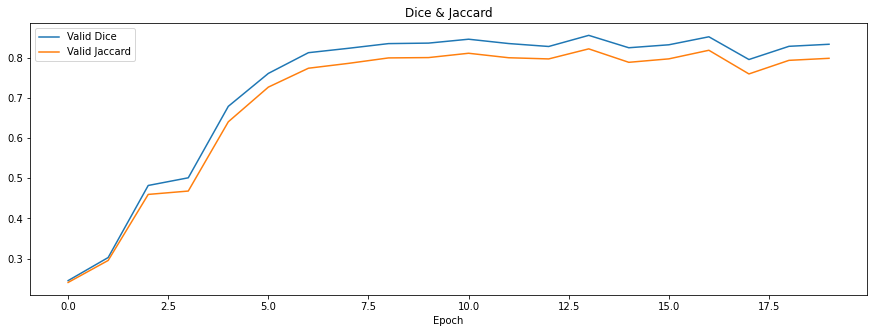

In [ ]:
# 비슷했음...Loss, Dice,Jaccard Curves
plt.figure(figsize=(15,5))
plt.plot(range(CFG.epochs),history['Valid Dice'],label='Valid Dice')
plt.plot(range(CFG.epochs),history['Valid Jaccard'],label='Valid Jaccard')
plt.title('Dice & Jaccard'); plt.xlabel('Epoch'); plt.ylabel('');plt.legend(); 
plt.show()

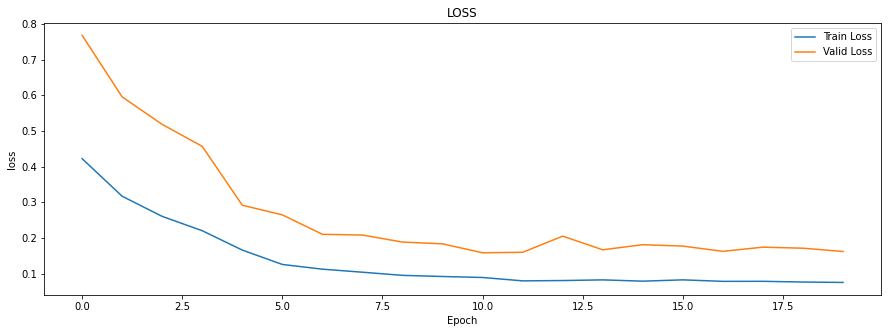

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(CFG.epochs),history['Train Loss'],label='Train Loss')
plt.plot(range(CFG.epochs),history['Valid Loss'],label='Valid Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

# 🔭 Prediction

In [ ]:
# loss = min(history['Valid Loss']) 

0.15945084319740047

In [ ]:
test_dataset = BuildDataset(df.query("fold==0 & empty==0").sample(frac=1.0), label=False, 
                            transforms=data_transforms['valid'])  # fold가 0이고(학습 안시켰고), empty가 0(false)인 3257개 이미지를 이미지 텐서로 변환. fold = transforms = 사이즈 리사이즈
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))  # 총 5개의 텐서 torch.Size([3, 224, 224])가 5개라 torch.Size([5, 3, 224, 224])
imgs = imgs.to(CFG.device, dtype=torch.float) # imgs는 정상적으로 생성되었다.

In [ ]:
preds = []
for fold in range(1):
    model= load_model("best_epoch-00.bin")  
    with torch.no_grad(): # autograd engine을 꺼버린다. 미분 계산 필요 없으니 메모리 사용량을 줄이고 연산 속도를 높히기 위함
        pred = model(imgs)  # torch.Size([5, 3, 224, 224])
        pred =(nn.Sigmoid()(pred)>0.5).double()  # pred값 0~1로 변환. 이게 0.5보다 크면 마스크. 
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach() # stack dim=0은 첫번째 차원을 늘리라는 의미,  gradient가 계산될 tensor의 경우 graph로 기록되는데, gpu 메모리 작업한 텐서를 cpu 메모리로 복사해서 이 계산 과정을 그래프에서 분리해낸다는 뜻이라고 함
#리스트에 담았던 pred값. torch.Size([5, 3, 224, 224])

In [ ]:
preds.shape

torch.Size([5, 3, 224, 224])

In [ ]:
preds

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


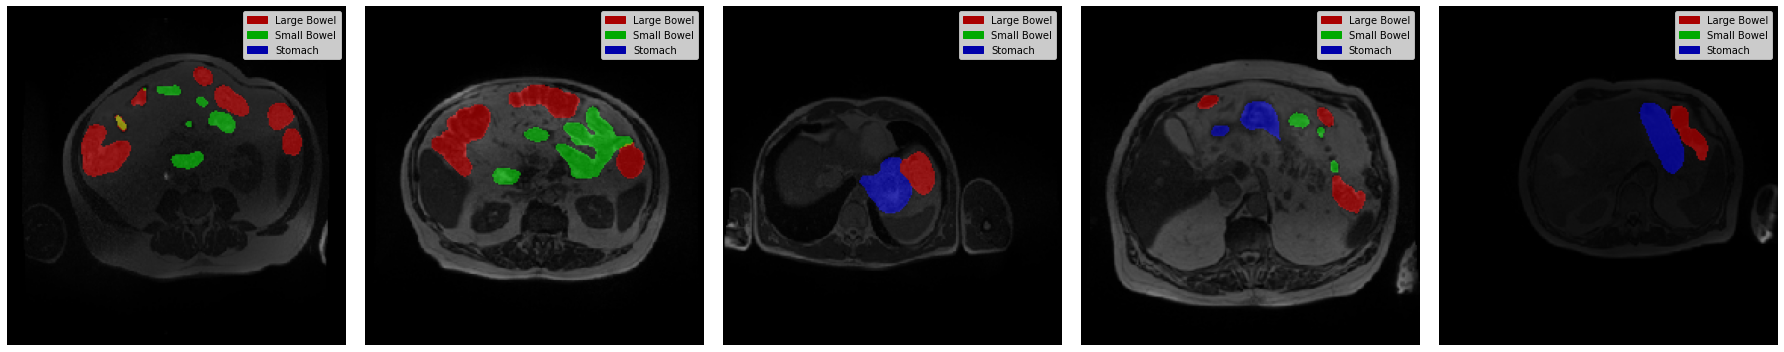

In [ ]:
plot_batch(imgs, preds, size=5)

## Test

### 변경된 클래스나 함수

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=False, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.ids        = df['id'].tolist()
        if 'msk_path' in df.columns:
            self.msk_paths  = df['mask_path'].tolist()
        else: # msk_path 없는 경우를 위해 만듦.(train.csv에 msk path 없으니까....)
            self.msk_paths = None
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        id_       = self.ids[index]
        img = []
        img = load_img(img_path)
        h, w = img.shape[:2]
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = cp.transpose(img, (2, 0, 1))# cp교체
            msk = cp.transpose(msk, (2, 0, 1))# cp교체
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = cp.transpose(img, (2, 0, 1))# cp교체
            return torch.tensor(img), id_, h, w # 텐서 말고도 id, h, w 다 나오게 한다. 이거로 트레인용 데이터셋 만들면 변수 개수 안맞아서 에러난다.

In [ ]:
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)  # 이 부분 때문에 plot_batch하면 에러생기더라. 히스토그램 이용해 화질 상승시키는 과정.
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [ ]:
BASE_PATH  = './dataset/uw-madison-gi-tract-image-segmentation'
CKPT_DIR = './dataset/uwmgi-unet-train-pytorch-ds'

In [ ]:
# sample_submission.csv 비어있음. 이 형태로 만드세요.
#sub_df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
#sub_df.head()

,id,class,predicted


In [ ]:
# 기본 train.csv 가지고 오면
#sub_df1 = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/train.csv')
#sub_df1.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:

sub_df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
if not len(sub_df): # 아무것도 들어있지 않은 상태
    debug = True
    sub_df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    sub_df = sub_df.drop(columns=['class','segmentation']).drop_duplicates()
else: # 안에 내용물이 있으면
    debug = False
    sub_df = sub_df.drop(columns=['class','predicted']).drop_duplicates() # id만 남겨서 중복행은 제거
sub_df = sub_df.progress_apply(get_metadata,axis=1) # 'case','day','slice' 만들어주기


100%|██████████| 1000/1000 [00:01<00:00, 690.25it/s]


In [ ]:
sub_df

,id,case,day,slice
0,case123_day20_slice_0001,123,20,1
3,case123_day20_slice_0002,123,20,2
6,case123_day20_slice_0003,123,20,3
9,case123_day20_slice_0004,123,20,4
12,case123_day20_slice_0005,123,20,5
...,...,...,...,...
2985,case133_day0_slice_0132,133,0,132
2988,case133_day0_slice_0133,133,0,133
2991,case133_day0_slice_0134,133,0,134
2994,case133_day0_slice_0135,133,0,135


In [ ]:
import pickle
# 경로 저장
if debug: # sample submission 비어있어서 True 되었으면
    with open("all_train_images.pickle","rb") as fr:
      paths =pickle.load(fr)
#     paths = sorted(paths)
else:
    paths = glob(f'./dataset/uw-madison-gi-tract-image-segmentation/test/**/*png',recursive=True) # test
#     paths = sorted(paths)
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.progress_apply(path2info, axis=1) # image_path	height	width
path_df.head()

100%|██████████| 38496/38496 [01:44<00:00, 368.68it/s]


,image_path,height,width,case,day,slice
0,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,15,0,6
1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,15,0,49
2,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,15,0,99
3,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,15,0,114
4,./dataset/uw-madison-gi-tract-image-segmentati...,266,266,15,0,15


In [ ]:
test_df = sub_df.merge(path_df, on=['case','day','slice'], how='left')  # case, day, slice 기준으로 df 합침
test_df.head()

,id,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,123,20,1,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
1,case123_day20_slice_0002,123,20,2,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
2,case123_day20_slice_0003,123,20,3,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
3,case123_day20_slice_0004,123,20,4,./dataset/uw-madison-gi-tract-image-segmentati...,266,266
4,case123_day20_slice_0005,123,20,5,./dataset/uw-madison-gi-tract-image-segmentati...,266,266


## Helper

In [ ]:
import cupy as cp # CuPy는 오픈소스 라이브러리로 NumPy 문법을 사용하며 NVIDIA GPU를 사용하여 행렬 연산으로 속도를 향상

def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = cp.array(msk)
    pixels = msk.flatten()
    pad    = cp.array([0])
    pixels = cp.concatenate([pad, pixels, pad])
    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks2rles(msks, ids, heights, widths):
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx in range(msks.shape[0]):
        height = heights[idx].item()
        width = widths[idx].item()
        msk = cv2.resize(msks[idx], 
                         dsize=(width, height), 
                         interpolation=cv2.INTER_NEAREST) # back to original shape
        rle = [None]*3
        for midx in [0, 1, 2]:
            rle[midx] = mask2rle(msk[...,midx])
        pred_strings.extend(rle)
        pred_ids.extend([ids[idx]]*len(rle))
        pred_classes.extend(['large_bowel', 'small_bowel', 'stomach'])
    return pred_strings, pred_ids, pred_classes

## inference

In [ ]:
@torch.no_grad()
def infer(model_paths, test_loader, num_log=1, thr=CFG.thr):  # 예측값 문자열로
    msks = []; imgs = [];
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx, (img, ids, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer ')):
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        size = img.size()
        msk = []
        msk = torch.zeros((size[0], 3, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        for path in model_paths:
            model = load_model(path)
            out   = model(img) # .squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out) # removing channel axis
            msk+=out/len(model_paths)
        msk = (msk.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        result = masks2rles(msk, ids, heights, widths)
        pred_strings.extend(result[0])
        pred_ids.extend(result[1])
        pred_classes.extend(result[2])
        if idx<num_log:
            img = img.permute((0,2,3,1)).cpu().detach().numpy()
            imgs.append(img[:10])
            msks.append(msk[:10])
        # del img, msk, out, model, result
        # gc.collect()
        # torch.cuda.empty_cache()
    return pred_strings, pred_ids, pred_classes, imgs, msks

In [ ]:
test_dataset = BuildDataset(test_df, transforms=data_transforms['valid']) #
test_loader  = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                          num_workers=4, shuffle=False, pin_memory=False)
model_paths  = glob(f'best_epoch*.bin')

pred_strings, pred_ids, pred_classes, imgs, msks = infer(model_paths, test_loader)

Infer : 100%|██████████| 4/4 [00:28<00:00,  7.17s/it]


In [ ]:
pred_df = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_strings
})
if not debug:
    sub_df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
    del sub_df['predicted']
else:
    sub_df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
    del sub_df['segmentation']
    
sub_df = sub_df.merge(pred_df, on=['id','class'])
sub_df.to_csv('nununu.csv',index=False)
display(sub_df.head(5))

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


### 확인

In [ ]:
old_df = pd.read_csv('./dataset/uw-madison-gi-tract-image-segmentation/train.csv')[:1000*3]
old_df.segmentation.isnull().sum() # 780개는 값이 있군

2220

In [ ]:
sub_df[(sub_df.predicted.str.count('')==1)] # 학습이 넘 적어서 predict 못한게 많았던 걸까?

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,
...,...,...,...
2995,case133_day0_slice_0135,small_bowel,
2996,case133_day0_slice_0135,stomach,
2997,case133_day0_slice_0136,large_bowel,
2998,case133_day0_slice_0136,small_bowel,


In [ ]:
sub_df[(sub_df.predicted.str.count('')!=1)] # 뭔가 쥐똥만큼 달라지긴 했는데....:-( 아니...쥐똥만큼 학습시키기는 했지만....음....이게 맞아...?

,id,class,predicted
188,case123_day20_slice_0063,stomach,24367 3 24631 6 24897 8 25162 7 25428 7 25694 ...
191,case123_day20_slice_0064,stomach,25442 3 25708 3 25974 3 26240 3 26506 2
194,case123_day20_slice_0065,stomach,24910 4 25176 5 25442 5 25708 5 25976 2 27560 ...
197,case123_day20_slice_0066,stomach,24901 2 25167 4 25432 5 25698 5 25964 5 26229 ...
200,case123_day20_slice_0067,stomach,22508 1 22772 5 23037 7 23303 8 23567 10 23833...
...,...,...,...
2911,case133_day0_slice_0107,small_bowel,37260 1 37618 3 37978 3 38340 1 38661 8 38700 ...
2913,case133_day0_slice_0108,large_bowel,34390 6 34745 17 35103 34 35463 34 35821 39 35...
2914,case133_day0_slice_0108,small_bowel,36900 3 37257 6 37585 3 37615 10 37945 3 37975...
2916,case133_day0_slice_0109,large_bowel,35865 11 36198 16 36222 17 36558 16 36582 17 3...


## Visualization

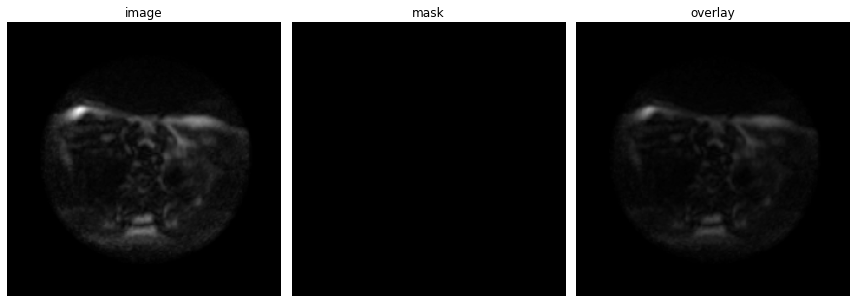

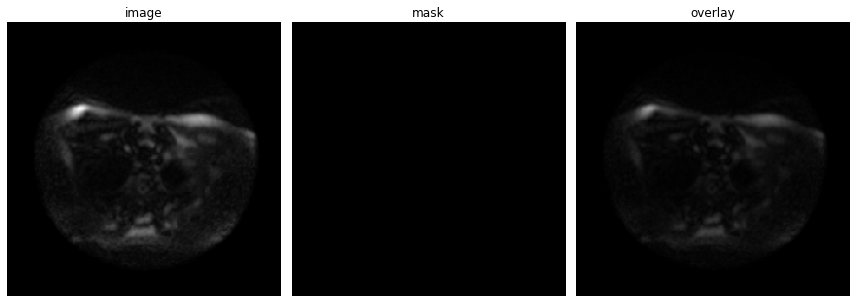

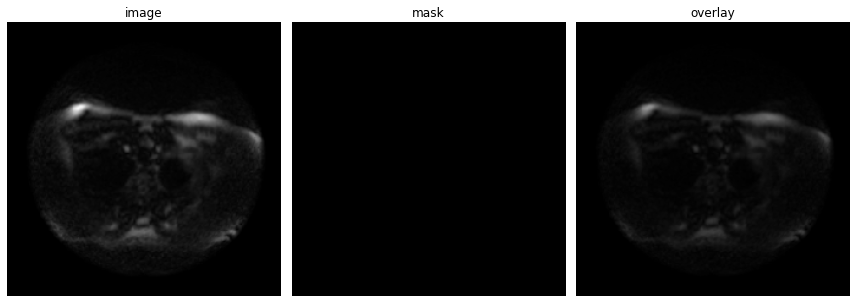

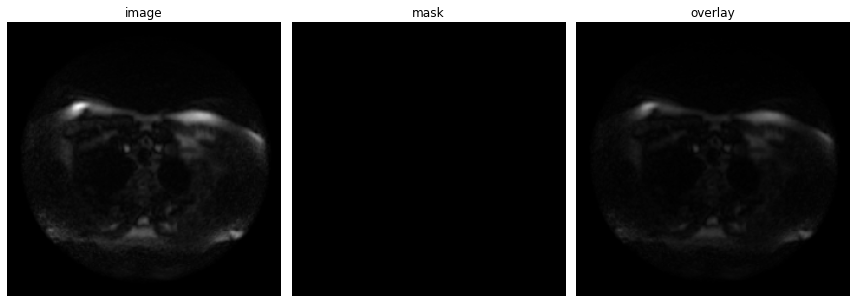

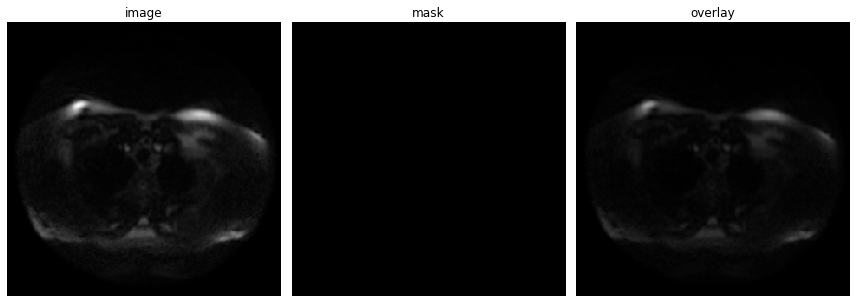

In [ ]:
for img, msk in zip(imgs[0][:5], msks[0][:5]):
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
    plt.axis('OFF'); plt.title('image')
    plt.subplot(1, 3, 2); plt.imshow(msk*255); plt.axis('OFF'); plt.title('mask')
    plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(msk*255, alpha=0.4);
    plt.axis('OFF'); plt.title('overlay')
    plt.tight_layout()
    plt.show()

# ✂️ Practice 싹다지워도됨

## sliding_window

In [ ]:
import sys
import torchvision.transforms as transforms
from tqdm import tqdm


'''TRAINING THE CHARACTER CLASSIFICATION NET'''


transform = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0), # 그리드 왜곡
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0) # 울렁울렁한 효과를 줘서 탄력적으로 변환시키는 것. alpha: 이미지를 흩는다 alpha_affine, sigma: 이미지를 살짝 회전, 늘임
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),  # 중간중간 구멍 뚫어서 다른 이미지 처럼 보이게한다.
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

'''TRAINING THE MODEL'''

Epochs = 50
for epoch in range(Epochs):
    total = 0
    for i, (imgs, msks) in enumerate(train_loader):
        try:
            output = Net(image.to(device))
            optimizer.zero_grad()
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()
            total += loss.item()
            if i % 10 == 0 and i != 0:
                print('Epoch : {}/{}, Iteration = {}, Loss = {}, Avg. Loss = {}'.format(
                    epoch, Epochs, i, loss.item(), total / i))
        except Exception as e:
            print(e)

torch.save(Net.state_dict(), 'Processes\\Back-end\\Saved Model\\MNISTNetCPU.pt')

In [ ]:
def sliding_window(image):
    li = []
    height, width, channel = image.shape

    #TAKING THE WINDOW'S WIDTH AS 0.7 TIMES THE HEIGHT
    window_width = int(height*0.7)

    i = 0
    for items in range(0, width-window_width//3, window_width//3):
        img = image[:, items:items+window_width, :]
        li.append((img, i))
        i += 1
    return li


def get_name_num(image):
    name_li = sliding_window(image)
    return name_li

In [ ]:
def recog_image(image_path):

    image = cv2.imread(image_path)

    slides = get_name_num(image)

    # Preprocessing, normlizing and converting the slides to tensor
    transformed_slides = transform_to_tensor(resize28X28(slides))

    #evaluating the image to text
    string = ocr.evaluate(transformed_slides, binClass, classNet, 1)

    print('Predicted string is : ' + string)

유넷 *수정

In [ ]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
          )     
        
    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x       

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 16 * n_channels)
        self.enc5 = Down(16 * n_channels, 16 * n_channels)
        
        self.dec1 = Up(32 * n_channels, 8 * n_channels)
        self.dec2 = Up(16 * n_channels, 4 * n_channels)
        self.dec3 = Up(8 * n_channels, 2 * n_channels)
        self.dec4 = Up(4 * n_channels, n_channels)
        self.dec5 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x6 = self.enc5(x5)
        
        mask = self.dec1(x6, x5)
        mask = self.dec2(mask, x4)
        mask = self.dec3(mask, x3)
        mask = self.dec4(mask, x2)
        mask = self.dec5(mask, x1)
        mask = self.out(mask)
        return mask

NameError: ignored

In [ ]:
def UNet(pretrained_weights = None,input_size = (128,128,1)):
    inp = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inp, outputs=[conv10])

    return model

옥타브 신경망

Tans unet

In [ ]:
!pip install -q transunet
!pip install -q segmentation_models

     |████████████████████████████████| 1.1 MB 5.6 MB/s 
     |████████████████████████████████| 50 kB 5.3 MB/s 


In [ ]:
import pandas as pd, numpy as np, random,os, shutil
import tensorflow as tf, re, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import sklearn
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow_addons as tfa
import yaml
from IPython import display as ipd
import json
from datetime import datetime

from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from IPython import display as ipd

import scipy
import warnings

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

# Show less log messages
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Set tf.keras as backend
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

In [ ]:
from transunet import TransUNet
model = TransUNet(image_size=224, pretrain=True)

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()

    return model

461225984/461217452 [==============================] - 4s 0us/step


In [ ]:
class CFG:
    wandb = True
    competition = "uwmgi-tf"
    _wandb_kernel = "awsaf49"
    debug = False
    exp_name = "v4"
    comment = "TransUNet-ResNet50V2-128x128-noaug-2.5D"

    # Use verbose=0 for silent, 1 for interactive
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Model & Backbone
    model_name = "TransUNet"
    backbone = "ResNet50V2"

    # Seeding for reproducibility
    seed = 101

    # Number of folds
    folds = 5

    # Which Folds to train
    selected_folds = [0, 1, 2, 3, 4]

    # Image Size
    img_size = [128, 128]
 
    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 15
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "dice_loss"
    optimizer = "Adam"
    lr = 5e-4
    lr_schedule = "CosineDecay"
    patience = 5

    # Augmentation
    augment = False
    transform = False

    # Transformation
    fill_mode = "constant"
    rot = 5.0  # proprtional
    shr = 5.0  # proprtional
    hzoom = 100.0  # inv proportional
    wzoom = 100.0  # inv proportional
    hshift = 10.0  # proportional
    wshift = 10.0  # proportional

    # Horizontal & Vertical Flip
    hflip = 0.5
    vflip = 0.5

    # Clip values to [0, 1]
    clip = False

    # CutOut
    drop_prob = 0.5
    drop_cnt = 10
    drop_size = 0.05

    # Jitter
    sat = [0.7, 1.3]  # saturation
    cont = [0.8, 1.2]  # contrast
    bri = 0.15  # brightness
    hue = 0.0  # hue

In [ ]:
def configure_device():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # connect to tpu cluster
        strategy = tf.distribute.TPUStrategy(tpu) # get strategy for tpu
        print('> Running on TPU ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device='TPU'
    except: # otherwise detect GPUs
        tpu = None
        gpus = tf.config.list_logical_devices('GPU') # get logical gpus
        ngpu = len(gpus)
        if ngpu: # if number of GPUs are 0 then CPU
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy() # connect to single gpu or cpu
            device='CPU'
    return strategy, device, tpu

In [ ]:
def seeding(SEED):
    """
    Sets all random seeds for the program (Python, NumPy, and TensorFlow).
    """
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    os.environ["TF_CUDNN_DETERMINISTIC"] = str(SEED)
    tf.random.set_seed(SEED)
    print("seeding done!!!")


seeding(CFG.seed)

seeding done!!!


In [ ]:
strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

> Running on TPU  grpc://10.69.43.18:8470 | Num of TPUs:  8
REPLICAS: 8


In [ ]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd


def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    # returns 3x3 transformmatrix which transforms indicies

    # CONVERT DEGREES TO RADIANS
    # rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.0

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst], axis=0), [3, 3])

    one = tf.constant([1], dtype="float32")
    zero = tf.constant([0], dtype="float32")

    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one, s2, zero, zero, c2, zero, zero, zero, one])
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat(
        [one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one]
    )
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat(
        [one, zero, height_shift, zero, one, width_shift, zero, zero, one]
    )

    return K.dot(
        shear_matrix, K.dot(zoom_matrix, shift_matrix)
    )  # K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


In [ ]:
# Decode image from bytestring to tensor
def decode_image(data, height, width, target_size=CFG.img_size):
    img = tf.io.decode_raw(data, out_type=tf.uint16)
    img = tf.reshape(img, [height, width, 3])  # explicit size needed for TPU
    img = tf.cast(img, tf.float32)
    img = tf.math.divide_no_nan(img, tf.math.reduce_max(img))  # scale image to [0, 1]
    img = tf.image.resize_with_pad(
        img, target_size[0], target_size[1], method="nearest"
    )  # resize with pad to avoid distortion
    img = tf.reshape(img, [*target_size, 3])  # reshape after resize
    return img


# Decode mask from bytestring to tensor
def decode_mask(data, height, width, target_size=CFG.img_size):
    msk = tf.io.decode_raw(data, out_type=tf.uint8)
    msk = tf.reshape(msk, [height, width, 3])  # explicit size needed for TPU
    msk = tf.cast(msk, tf.float32)
    msk = msk / 255.0  # scale mask data to[0, 1]
    msk = tf.image.resize_with_pad(
        msk, target_size[0], target_size[1], method="nearest"
    )
    msk = tf.reshape(msk, [*target_size, 3])  # reshape after resize
    return msk


# Read tfrecord data & parse it & do augmentation
def read_tfrecord(example, augment=True, return_id=False, dim=CFG.img_size):
    tfrec_format = {
        "id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(
        example, tfrec_format
    )  # parses a single example proto.
    image_id = example["id"]
    height = example["height"]
    width = example["width"]
    img = decode_image(example["image"], height, width, dim)  # access image
    msk = decode_mask(example["mask"], height, width, dim)  # access mask
    if augment:  # do augmentation
        img, msk = ShiftScaleRotate(img, msk, DIM=dim, p=0.75)
        img, msk = RandomFlip(img, msk, hflip_p=CFG.hflip, vflip_p=CFG.vflip)
        img = RandomJitter(img, CFG.hue, CFG.sat, CFG.cont, CFG.bri, p=0.8)
        img, msk = CutOut(
            img,
            msk,
            DIM=dim,
            PROBABILITY=CFG.drop_prob,
            CT=CFG.drop_cnt,
            SZ=CFG.drop_size,
        )
    img = tf.clip_by_value(img, 0, 1) if CFG.clip else img
    img = tf.reshape(img, [*dim, 3])
    msk = tf.reshape(msk, [*dim, 3])
    return (img, msk) if not return_id else (img, image_id, msk)


In [ ]:
from segmentation_models.base import functional as F
import tensorflow.keras.backend as K

kwargs = {}
kwargs["backend"] = K  # set tensorflow.keras as backend


def dice_coef(y_true, y_pred):
    """Dice coefficient"""
    dice = F.f_score(
        y_true,
        y_pred,
        beta=1,
        smooth=1e-5,
        per_image=False,
        threshold=0.5,
        **kwargs,
    )
    return dice


def tversky(y_true, y_pred, axis=(0, 1, 2), alpha=0.3, beta=0.7, smooth=0.0001):
    "Tversky metric"
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    tv = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) # calculate tversky
    tv = tf.math.reduce_mean(tv)
    return tv


def tversky_loss(y_true, y_pred):
    "Tversky Loss"
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    "Focal Tversky Loss: Focal Loss + Tversky Loss"
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


# Register custom objects
custom_objs = {
    "dice_loss": sm.losses.dice_loss,
    "dice_coef": dice_coef,
    "bce_dice_loss": sm.losses.bce_dice_loss,
    "bce_jaccard_loss": sm.losses.bce_jaccard_loss,
    "tversky_loss": tversky_loss,
    "focal_tversky_loss": focal_tversky_loss,
    "jaccard_loss": sm.losses.jaccard_loss,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
}
tf.keras.utils.get_custom_objects().update(custom_objs)

In [ ]:
def get_lr_callback():
    if CFG.lr_schedule == "ReduceLROnPlateau":
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=int(CFG.patience / 2),
            min_lr=CFG.lr / 1e2,
        )
    elif CFG.lr_schedule == "CosineDecay":
        lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=CFG.lr, decay_steps=CFG.epochs + 2, alpha=CFG.lr / 1e2
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    elif CFG.lr_schedule == "ExponentialDecay":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=CFG.lr,
            decay_steps=CFG.epochs + 2,
            decay_rate=0.05,
            staircase=False,
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    return lr_schedule

In [ ]:
def apply_embedding_weights(target_layer, source_weights):
    """Apply embedding weights to a target layer.

    Args:
        target_layer: The target layer to which weights will
            be applied.
        source_weights: The source weights, which will be
            resized as necessary.
    """
    expected_shape = target_layer.weights[0].shape
    if expected_shape == source_weights.shape:
        grid = source_weights
    elif expected_shape[1] == source_weights.shape[1] - 1:
        grid = source_weights[:, 1:]
    else:
        _, grid = source_weights[0, :1], source_weights[0, 1:]
        sin = int(np.sqrt(grid.shape[0]))
        sout = int(np.sqrt(expected_shape[1]))
        warnings.warn(
            "Resizing position embeddings from " f"{sin} to {sout}",
            UserWarning,
        )
        zoom = (sout / sin, sout / sin, 1)
        grid = scipy.ndimage.zoom(grid.reshape(sin, sin, -1), zoom, order=1).reshape(
            1, sout * sout, -1
        )
    target_layer.set_weights([grid])


def load_weights_numpy(model, params_path):
    """Load weights saved using Flax as a numpy array.

    Args:
        model: A Keras model to load the weights into.
        params_path: Filepath to a numpy archive.
    """
    params_dict = np.load(
        params_path, allow_pickle=False
    )  # pylint: disable=unexpected-keyword-arg
    source_keys = list(params_dict.keys())

    source_keys_used = []
    n_transformers = len(
        set(
            "/".join(k.split("/")[:2])
            for k in source_keys
            if k.startswith("Transformer/encoderblock_")
        )
    )
    n_transformers_out = sum(
        l.name.startswith("Transformer/encoderblock_") for l in model.layers
    )
    assert n_transformers == n_transformers_out, (
        f"Wrong number of transformers ("
        f"{n_transformers_out} in model vs. {n_transformers} in weights)."
    )

    matches = []
    for tidx in range(n_transformers):
        encoder = model.get_layer(f"Transformer/encoderblock_{tidx}")
        source_prefix = f"Transformer/encoderblock_{tidx}"
        matches.extend(
            [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]
                    ],
                }
                for norm, layer in [
                    ("LayerNorm_0", encoder.layernorm1),
                    ("LayerNorm_2", encoder.layernorm2),
                ]
            ]
            + [
                {
                    "layer": encoder.mlpblock.get_layer(
                        f"{source_prefix}/Dense_{mlpdense}"
                    ),
                    "keys": [
                        f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                }
                for mlpdense in [0, 1]
            ]
            + [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/MultiHeadDotProductAttention_1/{attvar}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                    "reshape": True,
                }
                for attvar, layer in [
                    ("query", encoder.att.query_dense),
                    ("key", encoder.att.key_dense),
                    ("value", encoder.att.value_dense),
                    ("out", encoder.att.combine_heads),
                ]
            ]
        )

    # Embedding kernel and bias
    matches.append(
        {
            "layer": model.get_layer("embedding"),
            "keys": [f"embedding/{name}" for name in ["kernel", "bias"]],
        }
    )

    matches.append(
        {
            "layer": model.get_layer("Transformer/encoder_norm"),
            "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
        }
    )
    apply_embedding_weights(
        target_layer=model.get_layer("Transformer/posembed_input"),
        source_weights=params_dict["Transformer/posembed_input/pos_embedding"],
    )
    source_keys_used.append("Transformer/posembed_input/pos_embedding")
    for match in matches:
        source_keys_used.extend(match["keys"])
        source_weights = [params_dict[k] for k in match["keys"]]
        if match.get("reshape", False):
            source_weights = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    source_weights, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(source_weights)

In [ ]:
class AddPositionEmbs(tfkl.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=self.trainable,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)


class MultiHeadSelfAttention(tfkl.Layer):
    def __init__(self, *args, trainable=True, n_heads, **kwargs):
        super().__init__(trainable=trainable, *args, **kwargs)
        self.n_heads = n_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        n_heads = self.n_heads
        if hidden_size % n_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {n_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // n_heads
        self.query_dense = tfkl.Dense(hidden_size, name="query")
        self.key_dense = tfkl.Dense(hidden_size, name="key")
        self.value_dense = tfkl.Dense(hidden_size, name="value")
        self.combine_heads = tfkl.Dense(hidden_size, name="out")

    # pylint: disable=no-self-use
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerBlock(tfkl.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, n_heads, mlp_dim, dropout, trainable=True, **kwargs):
        super().__init__(*args, trainable=trainable, **kwargs)
        self.n_heads = n_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            n_heads=self.n_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tfk.Sequential(
            [
                tfkl.Dense(
                    self.mlp_dim, activation="linear", name=f"{self.name}/Dense_0"
                ),
                tfkl.Lambda(lambda x: tfk.activations.gelu(x, approximate=False))
                if hasattr(tfk.activations, "gelu")
                else tfkl.Lambda(lambda x: tfa.activations.gelu(x, approximate=False)),
                tfkl.Dropout(self.dropout),
                tfkl.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tfkl.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_0")
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_2")
        self.dropout = tfkl.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights


def resnet_embeddings(x, image_size=224, n_skip=3):
    """Get resnet embeddings for Decoder"""
    resnet50v2 = tfk.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3)
    )
    _ = resnet50v2(x)
    layers = ["conv3_block4_preact_relu", "conv2_block3_preact_relu", "conv1_conv"]
    features = []
    if n_skip > 0:
        for l in layers:
            features.append(resnet50v2.get_layer(l).output)
    return resnet50v2, features

In [ ]:
L2_WEIGHT_DECAY = 1e-4


class SegmentationHead(tfkl.Layer):
    def __init__(
        self,
        name="seg_head",
        num_classes=9,
        kernel_size=1,
        final_act="sigmoid",
        **kwargs
    ):
        super(SegmentationHead, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.final_act = final_act

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.num_classes,
            kernel_size=self.kernel_size,
            padding="same",
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer=tfk.initializers.LecunNormal(),
        )
        self.act = tfkl.Activation(self.final_act)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.act(x)
        return x


class Conv2DReLu(tfkl.Layer):
    def __init__(self, filters, kernel_size, padding="same", strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            use_bias=False,
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer="lecun_normal",
        )

        self.bn = tfkl.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x


class DecoderBlock(tfkl.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.conv2 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.upsampling = tfkl.UpSampling2D(size=2, interpolation="bilinear")

    def call(self, inputs, skip=None):
        x = self.upsampling(inputs)
        if skip is not None:
            x = tf.concat([x, skip], axis=-1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderCup(tfkl.Layer):
    def __init__(self, decoder_channels, n_skip=3, **kwargs):
        super().__init__(**kwargs)
        self.decoder_channels = decoder_channels
        self.n_skip = n_skip

    def build(self, input_shape):
        self.conv_more = Conv2DReLu(filters=512, kernel_size=3)
        self.blocks = [DecoderBlock(filters=out_ch) for out_ch in self.decoder_channels]

    def call(self, hidden_states, features):
        x = self.conv_more(hidden_states)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


In [ ]:
MODELS_URL = "https://storage.googleapis.com/vit_models/imagenet21k/"


def load_pretrained(model, fname="R50+ViT-B_16.npz"):
    """Load model weights for a known configuration."""
    origin = MODELS_URL + fname
    local_filepath = tf.keras.utils.get_file(fname, origin, cache_subdir="weights")
    load_weights_numpy(model, local_filepath)


def TransUNet(
    image_size=224,
    patch_size=16,
    hybrid=True,
    grid=(14, 14),
    resnet_n_layers=(3, 4, 9),
    hidden_size=768,
    n_layers=12,
    n_heads=12,
    mlp_dim=3072,
    dropout=0.1,
    decoder_channels=[256, 128, 64, 16],
    n_skip=3,
    num_classes=3,
    final_act="sigmoid",
    pretrain=True,
    freeze_enc_cnn=True,
    name="TransUNet",
):
    # Tranformer Encoder
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size, image_size, 3))

    #  CNN + Transformer
    if hybrid:
        grid_size = grid
        patch_size = image_size // 16 // grid_size[0]
        if patch_size == 0:
            patch_size = 1
        resnet50v2, features = resnet_embeddings(
            x, image_size=image_size, n_skip=n_skip
        )
        if freeze_enc_cnn:
            resnet50v2.trainable = False
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
        y = x
        features = None

    y = tfkl.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
        trainable=not freeze_enc_cnn,
    )(y)
    y = tfkl.Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
    y = AddPositionEmbs(name="Transformer/posembed_input", trainable=True)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(n_layers):
        y, _ = TransformerBlock(
            n_heads=n_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
            trainable=True,
        )(y)
    y = tfkl.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

    # Decoder
    if len(decoder_channels):
        y = DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

    # Segmentation Head
    y = SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

    # Build Model
    model = tfk.models.Model(inputs=x, outputs=y, name=name)

    # Load Pretrain Weights
    if pretrain:
        load_pretrained(model)

    return model

In [ ]:
def get_model(name=CFG.model_name, loss=CFG.loss, backbone=CFG.backbone):
    model = TransUNet(image_size=CFG.img_size[0], freeze_enc_cnn=False, pretrain=True)

    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")

    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=[
            dice_coef,
            "precision",
            "recall",
        ],
    )
    return model

In [ ]:
model = get_model()
model.summary()

NameError: ignored

In [ ]:
def prepare_datasets(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True) # 80%  query 특정한 데이터를 보여달라는 요청.
    # print(train_df)
    valid_df = df.query("fold==@fold").reset_index(drop=True) # 20%
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train']) # 데이터셋에서 훈련용 데이터를 증가시킨 다음
    # print(train_dataset)
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    return train_dataset, valid_dataset

train_dataset, valid_dataset = prepare_datasets(fold=0, debug=True)

In [ ]:
M = {}
# Which Metrics to store
metrics = [
    "loss",
    "dice_coef",
    "precision",
    "recall",
]

# Build model in device
K.clear_session()
with strategy.scope():
    model = get_model(name=CFG.model_name, backbone=CFG.backbone, loss=CFG.loss)



# Train model
history = model.fit(
    train_dataset,
    epochs=CFG.epochs if not CFG.debug else 2,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    #         validation_steps = NUM_VALID/BATCH_SIZE,
    verbose=CFG.verbose,
    )

    # Convert dict history to df history
history = pd.DataFrame(history.history)

# Load best weights
model.load_weights("/kaggle/working/fold-%i.h5" % fold)

# Compute & save best valid result
print("\nValid Result:")
m = model.evaluate(
    get_dataset(
        VALID_FILENAMES,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False,
        repeat=False,
        cache=False,
    ),
    return_dict=True,
#        steps=NUM_VALID/BATCH_SIZE,
    verbose=1,
)
print()
    
# Store valid results
for fm in metrics:
    M["val_" + fm].append(m[fm])

# Plot Training History
if CFG.display_plot:
    plt.figure(figsize=(15, 5))
    plt.plot(
        np.arange(len(history["dice_coef"])),
        history["dice_coef"],
        "-o",
        label="Train Dice",
        color="#ff7f0e",
    )
    plt.plot(
        np.arange(len(history["dice_coef"])),
        history["val_dice_coef"],
        "-o",
        label="Val Dice",
        color="#1f77b4",
    )
    x = np.argmax(history["val_dice_coef"])
    y = np.max(history["val_dice_coef"])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#1f77b4")
    plt.text(x - 0.03 * xdist, y - 0.13 * ydist, "max dice\n%.2f" % y, size=14)
    plt.ylabel("dice_coef", size=14)
    plt.xlabel("Epoch", size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(
        np.arange(len(history["dice_coef"])),
        history["loss"],
        "-o",
        label="Train Loss",
        color="#2ca02c",
    )
    plt2.plot(
        np.arange(len(history["dice_coef"])),
        history["val_loss"],
        "-o",
        label="Val Loss",
        color="#d62728",
    )
    x = np.argmin(history["val_loss"])
    y = np.min(history["val_loss"])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s=200, color="#d62728")
    plt.text(x - 0.03 * xdist, y + 0.05 * ydist, "min loss", size=14)
    plt.ylabel("Loss", size=14)
    plt.title("FOLD %i" % (fold), size=18)
    plt.legend(loc=3)
    plt.savefig(f"fig-{fold}.png")
    plt.show()

IndentationError: ignored

**dataloder 에러 시도**

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
df['mask_path'][1]

'./dataset/uwmgi-mask-dataset/np/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.npy'

img가 정의되지 않았음. 경로에 문제가 있는건가? 

'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png'

In [ ]:
img = cv2.imread('.'+df['image_path'][1], cv2.IMREAD_UNCHANGED)# 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.

경로 앞에 '.' 붙여줌

In [ ]:
img # 잘 읽어 들였네...

In [ ]:
len(img)

TypeError: ignored

In [ ]:
print(img.shape)

NameError: ignored

In [ ]:
df.image_path[1]

'./dataset/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png'

In [ ]:
from google.colab.patches import cv2_imshow
import sys
import numpy as np
import cv2

cv2_imshow(img) # 이미지도 잘 불러오고...

In [ ]:
img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb img를 [1, 1, 3]배열 모양으로 반복해 쌓는다.
    img = img.astype('float32') # original is uint16
    mx = np.max(img)

In [ ]:
img = cv2.imread(df.image_path[1], cv2.IMREAD_UNCHANGED)# 이미지파일을 alpha channel까지 포함하여 읽어 들입니다. 안바꾸고 그대로 읽어옴
img.shape  

(266, 266)

In [ ]:
img[...,None].shape

(266, 266, 1)

In [ ]:
img = np.tile(img, [1, 1, 3])
img.shape

(1, 266, 798)

In [ ]:
img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb # 여기서 에러가 난다...? img를 [1, 1, 3]배열 모양으로 반복해 쌓는다.
img = img.astype('float32') # original is uint16
mx = np.max(img)
if mx:
    img/=mx # scale image to [0, 1]

In [ ]:
len(img)
print(img.shape)   # tile로 차원 변환이 이렇게 늘어났다.

In [ ]:
df.image_path[1]

In [ ]:
df.mask_path[1]

In [ ]:
# TypeError: Caught TypeError in DataLoader worker process 0.
imgs, msks = next(iter(train_loader)) # dataloder 반복자, next로 차례대로. 분리
imgs.size(), msks.size()


## Meta Pseudo Labels 

### utils

In [ ]:
import logging
import os
import shutil
from collections import OrderedDict

import torch
from torch import distributed as dist
from torch import nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)


def reduce_tensor(tensor, n):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= n
    return rt


def create_loss_fn(args):
    # if args.label_smoothing > 0:
    #     criterion = SmoothCrossEntropyV2(alpha=args.label_smoothing)
    # else:  
    criterion = nn.CrossEntropyLoss(label_smoothing=args.label_smoothing)
    return criterion.to(args.device)


def module_load_state_dict(model, state_dict):
    try:
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:]  # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    except:
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = f'module.{k}'  # add `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)


def model_load_state_dict(model, state_dict):
    try:
        model.load_state_dict(state_dict)
    except:
        module_load_state_dict(model, state_dict)


def save_checkpoint(args, state, is_best, finetune=False):
    os.makedirs(args.save_path, exist_ok=True)
    if finetune:
        name = f'{args.name}_finetune'
    else:
        name = args.name
    filename = f'{args.save_path}/{name}_last.pth.tar'
    torch.save(state, filename, _use_new_zipfile_serialization=False)
    if is_best:
        shutil.copyfile(filename, f'{args.save_path}/{args.name}_best.pth.tar')


def accuracy(output, target, topk=(1,)):
    output = output.to(torch.device('cpu'))
    target = target.to(torch.device('cpu'))
    maxk = max(topk)
    batch_size = target.shape[0]

    _, idx = output.sort(dim=1, descending=True)
    pred = idx.narrow(1, 0, maxk).t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(dim=0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class SmoothCrossEntropy(nn.Module):
    def __init__(self, alpha=0.1):
        super(SmoothCrossEntropy, self).__init__()
        self.alpha = alpha

    def forward(self, logits, labels):
        if self.alpha == 0:
            loss = F.cross_entropy(logits, labels)
        else:
            num_classes = logits.shape[-1]
            alpha_div_k = self.alpha / num_classes
            target_probs = F.one_hot(labels, num_classes=num_classes).float() * \
                (1. - self.alpha) + alpha_div_k
            loss = (-(target_probs * torch.log_softmax(logits, dim=-1)).sum(dim=-1)).mean()
        return loss


class SmoothCrossEntropyV2(nn.Module):
    """
    NLL loss with label smoothing.
    """

    def __init__(self, label_smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super().__init__()
        assert label_smoothing < 1.0
        self.smoothing = label_smoothing
        self.confidence = 1. - label_smoothing

    def forward(self, x, target):
        if self.smoothing == 0:
            loss = F.cross_entropy(x, target)
        else:
            logprobs = F.log_softmax(x, dim=-1)
            nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
            nll_loss = nll_loss.squeeze(1)
            smooth_loss = -logprobs.mean(dim=-1)
            loss = (self.confidence * nll_loss + self.smoothing * smooth_loss).mean()
        return loss


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Meta Pseudo Labels 
import argparse
import logging

logger = logging.getLogger(__name__)

# 인자값을 받을 수 있는 인스턴스 생성
parser = argparse.ArgumentParser()

# 입력받을 인자값 등록
parser.add_argument('--name', type=str, required=True, help='experiment name')
parser.add_argument('--data-path', default='./data', type=str, help='data path')
parser.add_argument('--save-path', default='./checkpoint', type=str, help='save path')
parser.add_argument('--dataset', default='cifar10', type=str,
                    choices=['cifar10', 'cifar100'], help='dataset name')
parser.add_argument('--num-labeled', type=int, default=4000, help='number of labeled data')
parser.add_argument("--expand-labels", action="store_true", help="expand labels to fit eval steps")
parser.add_argument('--total-steps', default=300000, type=int, help='number of total steps to run')
parser.add_argument('--eval-step', default=1000, type=int, help='number of eval steps to run')
parser.add_argument('--start-step', default=0, type=int,
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--workers', default=4, type=int, help='number of workers')
parser.add_argument('--num-classes', default=10, type=int, help='number of classes')
parser.add_argument('--resize', default=32, type=int, help='resize image')
parser.add_argument('--batch-size', default=64, type=int, help='train batch size')
parser.add_argument('--teacher-dropout', default=0, type=float, help='dropout on last dense layer')
parser.add_argument('--student-dropout', default=0, type=float, help='dropout on last dense layer')
parser.add_argument('--teacher_lr', default=0.01, type=float, help='train learning late')
parser.add_argument('--student_lr', default=0.01, type=float, help='train learning late')
parser.add_argument('--momentum', default=0.9, type=float, help='SGD Momentum')
parser.add_argument('--nesterov', action='store_true', help='use nesterov')
parser.add_argument('--weight-decay', default=0, type=float, help='train weight decay')
parser.add_argument('--ema', default=0, type=float, help='EMA decay rate')
parser.add_argument('--warmup-steps', default=0, type=int, help='warmup steps')
parser.add_argument('--student-wait-steps', default=0, type=int, help='warmup steps')
parser.add_argument('--grad-clip', default=1e9, type=float, help='gradient norm clipping')
parser.add_argument('--resume', default='', type=str, help='path to checkpoint')
parser.add_argument('--evaluate', action='store_true', help='only evaluate model on validation set')
parser.add_argument('--finetune', action='store_true',
                    help='only finetune model on labeled dataset')
parser.add_argument('--finetune-epochs', default=625, type=int, help='finetune epochs')
parser.add_argument('--finetune-batch-size', default=512, type=int, help='finetune batch size')
parser.add_argument('--finetune-lr', default=3e-5, type=float, help='finetune learning late')
parser.add_argument('--finetune-weight-decay', default=0, type=float, help='finetune weight decay')
parser.add_argument('--finetune-momentum', default=0.9, type=float, help='finetune SGD Momentum')
parser.add_argument('--seed', default=None, type=int, help='seed for initializing training')
parser.add_argument('--label-smoothing', default=0, type=float, help='label smoothing alpha')
parser.add_argument('--mu', default=7, type=int, help='coefficient of unlabeled batch size')
parser.add_argument('--threshold', default=0.95, type=float, help='pseudo label threshold')
parser.add_argument('--temperature', default=1, type=float, help='pseudo label temperature')
parser.add_argument('--lambda-u', default=1, type=float, help='coefficient of unlabeled loss')
parser.add_argument('--uda-steps', default=1, type=float, help='warmup steps of lambda-u')
parser.add_argument("--randaug", nargs="+", type=int, help="use it like this. --randaug 2 10")
parser.add_argument("--amp", action="store_true", help="use 16-bit (mixed) precision")
parser.add_argument('--world-size', default=-1, type=int,
                    help='number of nodes for distributed training')
parser.add_argument("--local_rank", type=int, default=-1,
                    help="For distributed training: local_rank")

_StoreAction(option_strings=['--local_rank'], dest='local_rank', nargs=None, const=None, default=-1, type=<class 'int'>, choices=None, help='For distributed training: local_rank', metavar=None)

In [ ]:
# 입력받은 인자값을 args에 저장 (type: namespace)
args = parser.parse_args()

%tb

usage: ipykernel_launcher.py [-h] --name NAME [--data-path DATA_PATH]
                             [--save-path SAVE_PATH]
                             [--dataset {cifar10,cifar100}]
                             [--num-labeled NUM_LABELED] [--expand-labels]
                             [--total-steps TOTAL_STEPS]
                             [--eval-step EVAL_STEP] [--start-step START_STEP]
                             [--workers WORKERS] [--num-classes NUM_CLASSES]
                             [--resize RESIZE] [--batch-size BATCH_SIZE]
                             [--teacher-dropout TEACHER_DROPOUT]
                             [--student-dropout STUDENT_DROPOUT]
                             [--teacher_lr TEACHER_LR]
                             [--student_lr STUDENT_LR] [--momentum MOMENTUM]
                             [--nesterov] [--weight-decay WEIGHT_DECAY]
                             [--ema EMA] [--warmup-steps WARMUP_STEPS]
                             [--student-wait-steps 

SystemExit: ignored

In [ ]:
%tb

SystemExit: ignored

In [ ]:
args.best_top1 = 0.
args.best_top5 = 0.


args.gpu = 0
args.world_size = 1

args.device = torch.device('cuda', args.gpu)

### models

In [ ]:
from copy import deepcopy
import logging
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)


class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)

    def forward(self, input):
        return self.module(input)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.parameters(), model.parameters()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))
            for ema_v, model_v in zip(self.module.buffers(), model.buffers()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(model_v)

    def update_parameters(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def state_dict(self):
        return self.module.state_dict()

    def load_state_dict(self, state_dict):
        self.module.load_state_dict(state_dict)


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropout=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.01, eps=1e-3)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.01, eps=1e-3)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.dropout = dropout
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes,
                                                                kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.dropout > 0:
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropout=0.0,
                 activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block, in_planes, out_planes, nb_layers, stride, dropout, activate_before_residual)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropout,
                    activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, dropout, activate_before_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, dropout=0.0, dense_dropout=0.0):
        super(WideResNet, self).__init__()
        channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, channels[0], channels[1], block, 1, dropout, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(
            n, channels[1], channels[2], block, 2, dropout)
        # 3rd block
        self.block3 = NetworkBlock(
            n, channels[2], channels[3], block, 2, dropout)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[3], momentum=0.01, eps=1e-3)
        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(dense_dropout)
        self.fc = nn.Linear(channels[3], num_classes)
        self.channels = channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(self.drop(out))


def build_wideresnet(args):
    if args.dataset == "cifar10":
        depth, widen_factor = 28, 2
    elif args.dataset == 'cifar100':
        depth, widen_factor = 28, 8

    model = WideResNet(num_classes=args.num_classes,
                       depth=depth,
                       widen_factor=widen_factor,
                       dropout=0,
                       dense_dropout=args.dense_dropout)
    if args.local_rank in [-1, 0]:
        logger.info(f"Model: WideResNet {depth}x{widen_factor}")
        logger.info(f"Total params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
    return model

### mains

In [ ]:
!pip install easydict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
a={'key':0, 'apple':3}

In [ ]:
a

{'apple': 3, 'key': 0}

In [ ]:
df['empty'].value_counts()[0]

16590

In [ ]:
from easydict import EasyDict
d = EasyDict({'num_labeled':df['empty'].value_counts()[1], 
              'expand_labels':df['empty'].value_counts()[0],
              'teacher_dropout':0,
              'student_dropout':0})

In [ ]:
logger = logging.getLogger(__name__)

parser = argparse.ArgumentParser()
parser.add_argument('--name', type=str, required=True, help='experiment name')
parser.add_argument('--data-path', default='./data', type=str, help='data path')
parser.add_argument('--save-path', default='./checkpoint', type=str, help='save path')
parser.add_argument('--dataset', default='cifar10', type=str,
                    choices=['cifar10', 'cifar100'], help='dataset name')
parser.add_argument('--num-labeled', type=int, default=4000, help='number of labeled data')
parser.add_argument("--expand-labels", action="store_true", help="expand labels to fit eval steps")
parser.add_argument('--total-steps', default=300000, type=int, help='number of total steps to run')
parser.add_argument('--eval-step', default=1000, type=int, help='number of eval steps to run')
parser.add_argument('--start-step', default=0, type=int,
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--workers', default=4, type=int, help='number of workers')
parser.add_argument('--num-classes', default=10, type=int, help='number of classes')
parser.add_argument('--resize', default=32, type=int, help='resize image')
parser.add_argument('--batch-size', default=64, type=int, help='train batch size')
parser.add_argument('--teacher-dropout', default=0, type=float, help='dropout on last dense layer')
parser.add_argument('--student-dropout', default=0, type=float, help='dropout on last dense layer')
parser.add_argument('--teacher_lr', default=0.01, type=float, help='train learning late')
parser.add_argument('--student_lr', default=0.01, type=float, help='train learning late')
parser.add_argument('--momentum', default=0.9, type=float, help='SGD Momentum')
parser.add_argument('--nesterov', action='store_true', help='use nesterov')
parser.add_argument('--weight-decay', default=0, type=float, help='train weight decay')
parser.add_argument('--ema', default=0, type=float, help='EMA decay rate')
parser.add_argument('--warmup-steps', default=0, type=int, help='warmup steps')
parser.add_argument('--student-wait-steps', default=0, type=int, help='warmup steps')
parser.add_argument('--grad-clip', default=0., type=float, help='gradient norm clipping')
parser.add_argument('--resume', default='', type=str, help='path to checkpoint')
parser.add_argument('--evaluate', action='store_true', help='only evaluate model on validation set')
parser.add_argument('--finetune', action='store_true',
                    help='only finetune model on labeled dataset')
parser.add_argument('--finetune-epochs', default=125, type=int, help='finetune epochs')
parser.add_argument('--finetune-batch-size', default=512, type=int, help='finetune batch size')
parser.add_argument('--finetune-lr', default=1e-5, type=float, help='finetune learning late')
parser.add_argument('--finetune-weight-decay', default=0, type=float, help='finetune weight decay')
parser.add_argument('--finetune-momentum', default=0, type=float, help='finetune SGD Momentum')
parser.add_argument('--seed', default=None, type=int, help='seed for initializing training')
parser.add_argument('--label-smoothing', default=0, type=float, help='label smoothing alpha')
parser.add_argument('--mu', default=7, type=int, help='coefficient of unlabeled batch size')
parser.add_argument('--threshold', default=0.95, type=float, help='pseudo label threshold')
parser.add_argument('--temperature', default=1, type=float, help='pseudo label temperature')
parser.add_argument('--lambda-u', default=1, type=float, help='coefficient of unlabeled loss')
parser.add_argument('--uda-steps', default=1, type=float, help='warmup steps of lambda-u')
parser.add_argument("--randaug", nargs="+", type=int, help="use it like this. --randaug 2 10")
parser.add_argument("--amp", action="store_true", help="use 16-bit (mixed) precision")
parser.add_argument('--world-size', default=-1, type=int,
                    help='number of nodes for distributed training')
parser.add_argument("--local_rank", type=int, default=-1,
                    help="For distributed training: local_rank")


NameError: ignored

In [ ]:
import argparse
import logging
import math
import os
import random
import time

import numpy as np
import torch
from torch.cuda import amp
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm



def get_cosine_schedule_with_warmup(optimizer,
                                    num_warmup_steps,
                                    num_training_steps,
                                    num_wait_steps=0,
                                    num_cycles=0.5,
                                    last_epoch=-1):

  def train_loop(args, labeled_loader, unlabeled_loader, test_loader,
               teacher_model, student_model, avg_student_model, criterion,
               t_optimizer, s_optimizer, t_scheduler, s_scheduler, t_scaler, s_scaler):
    logger.info("***** Running Training *****")
    logger.info(f"   Task = {args.dataset}@{args.num_labeled}")
    logger.info(f"   Total steps = {args.total_steps}")

    if args.world_size > 1:
        labeled_epoch = 0
        unlabeled_epoch = 0
        labeled_loader.sampler.set_epoch(labeled_epoch)
        unlabeled_loader.sampler.set_epoch(unlabeled_epoch)

    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)

#     moving_dot_product = torch.empty(1).to(args.device)
#     limit = 3.0**(0.5)  # 3 = 6 / (f_in + f_out)
#     nn.init.uniform_(moving_dot_product, -limit, limit)

    for step in range(args.start_step, args.total_steps):
        if step % args.eval_step == 0:
            pbar = tqdm(range(args.eval_step), disable=args.local_rank not in [-1, 0])
            batch_time = AverageMeter()
            data_time = AverageMeter()
            s_losses = AverageMeter()
            t_losses = AverageMeter()
            t_losses_l = AverageMeter()
            t_losses_u = AverageMeter()
            t_losses_mpl = AverageMeter()
            mean_mask = AverageMeter()

        teacher_model.train()
        student_model.train()
        end = time.time()

        try:
            images_l, targets = labeled_iter.next()
        except:
            if args.world_size > 1:
                labeled_epoch += 1
                labeled_loader.sampler.set_epoch(labeled_epoch)
            labeled_iter = iter(labeled_loader)
            images_l, targets = labeled_iter.next()

        try:
            (images_uw, images_us), _ = unlabeled_iter.next()
        except:
            if args.world_size > 1:
                unlabeled_epoch += 1
                unlabeled_loader.sampler.set_epoch(unlabeled_epoch)
            unlabeled_iter = iter(unlabeled_loader)
            (images_uw, images_us), _ = unlabeled_iter.next()

        data_time.update(time.time() - end)

        images_l = images_l.to(args.device)
        images_uw = images_uw.to(args.device)
        images_us = images_us.to(args.device)
        targets = targets.to(args.device)
        with amp.autocast(enabled=args.amp):
            batch_size = images_l.shape[0]
            t_images = torch.cat((images_l, images_uw, images_us))
            t_logits = teacher_model(t_images)
            t_logits_l = t_logits[:batch_size]
            t_logits_uw, t_logits_us = t_logits[batch_size:].chunk(2)
            del t_logits

            t_loss_l = criterion(t_logits_l, targets)

            soft_pseudo_label = torch.softmax(t_logits_uw.detach()/args.temperature, dim=-1)
            max_probs, hard_pseudo_label = torch.max(soft_pseudo_label, dim=-1)
            mask = max_probs.ge(args.threshold).float()
            t_loss_u = torch.mean(
                -(soft_pseudo_label * torch.log_softmax(t_logits_us, dim=-1)).sum(dim=-1) * mask
            )
            weight_u = args.lambda_u * min(1., (step+1) / args.uda_steps)
            t_loss_uda = t_loss_l + weight_u * t_loss_u

            s_images = torch.cat((images_l, images_us))
            s_logits = student_model(s_images)
            s_logits_l = s_logits[:batch_size]
            s_logits_us = s_logits[batch_size:]
            del s_logits

            s_loss_l_old = F.cross_entropy(s_logits_l.detach(), targets)
            s_loss = criterion(s_logits_us, hard_pseudo_label)

        s_scaler.scale(s_loss).backward()
        if args.grad_clip > 0:
            s_scaler.unscale_(s_optimizer)
            nn.utils.clip_grad_norm_(student_model.parameters(), args.grad_clip)
        s_scaler.step(s_optimizer)
        s_scaler.update()
        s_scheduler.step()
        if args.ema > 0:
            avg_student_model.update_parameters(student_model)

        with amp.autocast(enabled=args.amp):
            with torch.no_grad():
                s_logits_l = student_model(images_l)
            s_loss_l_new = F.cross_entropy(s_logits_l.detach(), targets)
#             dot_product = s_loss_l_new - s_loss_l_old
            # test
            dot_product = s_loss_l_old - s_loss_l_new
#             moving_dot_product = moving_dot_product * 0.99 + dot_product * 0.01
#             dot_product = dot_product - moving_dot_product
            _, hard_pseudo_label = torch.max(t_logits_us.detach(), dim=-1)
            t_loss_mpl = dot_product * F.cross_entropy(t_logits_us, hard_pseudo_label)
            t_loss = t_loss_uda + t_loss_mpl

        t_scaler.scale(t_loss).backward()
        if args.grad_clip > 0:
            t_scaler.unscale_(t_optimizer)
            nn.utils.clip_grad_norm_(teacher_model.parameters(), args.grad_clip)
        t_scaler.step(t_optimizer)
        t_scaler.update()
        t_scheduler.step()

        teacher_model.zero_grad()
        student_model.zero_grad()

        if args.world_size > 1:
            s_loss = reduce_tensor(s_loss.detach(), args.world_size)
            t_loss = reduce_tensor(t_loss.detach(), args.world_size)
            t_loss_l = reduce_tensor(t_loss_l.detach(), args.world_size)
            t_loss_u = reduce_tensor(t_loss_u.detach(), args.world_size)
            t_loss_mpl = reduce_tensor(t_loss_mpl.detach(), args.world_size)
            mask = reduce_tensor(mask, args.world_size)

        s_losses.update(s_loss.item())
        t_losses.update(t_loss.item())
        t_losses_l.update(t_loss_l.item())
        t_losses_u.update(t_loss_u.item())
        t_losses_mpl.update(t_loss_mpl.item())
        mean_mask.update(mask.mean().item())

        batch_time.update(time.time() - end)
        pbar.set_description(
            f"Train Iter: {step+1:3}/{args.total_steps:3}. "
            f"LR: {get_lr(s_optimizer):.4f}. Data: {data_time.avg:.2f}s. "
            f"Batch: {batch_time.avg:.2f}s. S_Loss: {s_losses.avg:.4f}. "
            f"T_Loss: {t_losses.avg:.4f}. Mask: {mean_mask.avg:.4f}. ")
        pbar.update()
        if args.local_rank in [-1, 0]:
            args.writer.add_scalar("lr", get_lr(s_optimizer), step)

        args.num_eval = step//args.eval_step
        if (step+1) % args.eval_step == 0:
            pbar.close()
            if args.local_rank in [-1, 0]:
                args.writer.add_scalar("train/1.s_loss", s_losses.avg, args.num_eval)
                args.writer.add_scalar("train/2.t_loss", t_losses.avg, args.num_eval)
                args.writer.add_scalar("train/3.t_labeled", t_losses_l.avg, args.num_eval)
                args.writer.add_scalar("train/4.t_unlabeled", t_losses_u.avg, args.num_eval)
                args.writer.add_scalar("train/5.t_mpl", t_losses_mpl.avg, args.num_eval)
                args.writer.add_scalar("train/6.mask", mean_mask.avg, args.num_eval)

                test_model = avg_student_model if avg_student_model is not None else student_model
                test_loss, top1, top5 = evaluate(args, test_loader, test_model, criterion)

                args.writer.add_scalar("test/loss", test_loss, args.num_eval)
                args.writer.add_scalar("test/acc@1", top1, args.num_eval)
                args.writer.add_scalar("test/acc@5", top5, args.num_eval)

                is_best = top1 > args.best_top1
                if is_best:
                    args.best_top1 = top1
                    args.best_top5 = top5

                logger.info(f"top-1 acc: {top1:.2f}")
                logger.info(f"Best top-1 acc: {args.best_top1:.2f}")

                save_checkpoint(args, {
                    'step': step + 1,
                    'teacher_state_dict': teacher_model.state_dict(),
                    'student_state_dict': student_model.state_dict(),
                    'avg_state_dict': avg_student_model.state_dict() if avg_student_model is not None else None,
                    'best_top1': args.best_top1,
                    'best_top5': args.best_top5,
                    'teacher_optimizer': t_optimizer.state_dict(),
                    'student_optimizer': s_optimizer.state_dict(),
                    'teacher_scheduler': t_scheduler.state_dict(),
                    'student_scheduler': s_scheduler.state_dict(),
                    'teacher_scaler': t_scaler.state_dict(),
                    'student_scaler': s_scaler.state_dict(),
                }, is_best)
    # finetune
    del t_scaler, t_scheduler, t_optimizer, teacher_model, unlabeled_loader
    del s_scaler, s_scheduler, s_optimizer
    ckpt_name = f'{args.save_path}/{args.name}_best.pth.tar'
    loc = f'cuda:{args.gpu}'
    checkpoint = torch.load(ckpt_name, map_location=loc)
    logger.info(f"=> loading checkpoint '{ckpt_name}'")
    if checkpoint['avg_state_dict'] is not None:
        model_load_state_dict(student_model, checkpoint['avg_state_dict'])
    else:
        model_load_state_dict(student_model, checkpoint['student_state_dict'])
    finetune(args, labeled_loader, test_loader, student_model, criterion)
    return


def evaluate(args, test_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    model.eval()
    test_iter = tqdm(test_loader, disable=args.local_rank not in [-1, 0])
    with torch.no_grad():
        end = time.time()
        for step, (images, targets) in enumerate(test_iter):
            data_time.update(time.time() - end)
            batch_size = targets.shape[0]
            images = images.to(args.device)
            targets = targets.to(args.device)
            with amp.autocast(enabled=args.amp):
                outputs = model(images)
                loss = criterion(outputs, targets)

            acc1, acc5 = accuracy(outputs, targets, (1, 5))
            losses.update(loss.item(), batch_size)
            top1.update(acc1[0], batch_size)
            top5.update(acc5[0], batch_size)
            batch_time.update(time.time() - end)
            end = time.time()
            test_iter.set_description(
                f"Test Iter: {step+1:3}/{len(test_loader):3}. Data: {data_time.avg:.2f}s. "
                f"Batch: {batch_time.avg:.2f}s. Loss: {losses.avg:.4f}. "
                f"top1: {top1.avg:.2f}. top5: {top5.avg:.2f}. ")

        test_iter.close()
        return losses.avg, top1.avg, top5.avg


def finetune(args, train_loader, test_loader, model, criterion):
    train_sampler = RandomSampler if args.local_rank == -1 else DistributedSampler
    labeled_loader = DataLoader(
        train_loader.dataset,
        sampler=train_sampler(train_loader.dataset),
        batch_size=args.finetune_batch_size,
        num_workers=args.workers,
        pin_memory=True)
    optimizer = optim.SGD(model.parameters(),
                          lr=args.finetune_lr,
                          momentum=args.finetune_momentum,
                          weight_decay=args.finetune_weight_decay)
    scaler = amp.GradScaler(enabled=args.amp)

    logger.info("***** Running Finetuning *****")
    logger.info(f"   Finetuning steps = {len(labeled_loader)*args.finetune_epochs}")

    for epoch in range(args.finetune_epochs):
        if args.world_size > 1:
            labeled_loader.sampler.set_epoch(epoch+624)

        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        model.train()
        end = time.time()
        labeled_iter = tqdm(labeled_loader, disable=args.local_rank not in [-1, 0])
        for step, (images, targets) in enumerate(labeled_iter):
            data_time.update(time.time() - end)
            batch_size = targets.shape[0]
            images = images.to(args.device)
            targets = targets.to(args.device)
            with amp.autocast(enabled=args.amp):
                model.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if args.world_size > 1:
                loss = reduce_tensor(loss.detach(), args.world_size)
            losses.update(loss.item(), batch_size)
            batch_time.update(time.time() - end)
            labeled_iter.set_description(
                f"Finetune Epoch: {epoch+1:2}/{args.finetune_epochs:2}. Data: {data_time.avg:.2f}s. "
                f"Batch: {batch_time.avg:.2f}s. Loss: {losses.avg:.4f}. ")
        labeled_iter.close()
        if args.local_rank in [-1, 0]:
            args.writer.add_scalar("finetune/train_loss", losses.avg, epoch)
            test_loss, top1, top5 = evaluate(args, test_loader, model, criterion)
            args.writer.add_scalar("finetune/test_loss", test_loss, epoch)
            args.writer.add_scalar("finetune/acc@1", top1, epoch)
            args.writer.add_scalar("finetune/acc@5", top5, epoch)
            is_best = top1 > args.best_top1
            if is_best:
                args.best_top1 = top1
                args.best_top5 = top5

            logger.info(f"top-1 acc: {top1:.2f}")
            logger.info(f"Best top-1 acc: {args.best_top1:.2f}")

            save_checkpoint(args, {
                'step': step + 1,
                'best_top1': args.best_top1,
                'best_top5': args.best_top5,
                'student_state_dict': model.state_dict(),
                'avg_state_dict': None,
                'student_optimizer': optimizer.state_dict(),
            }, is_best, finetune=True)
    return


def main():
    args = parser.parse_args('')
    args.best_top1 = 0.
    args.best_top5 = 0.

    if args.local_rank != -1:
        args.gpu = args.local_rank
        torch.distributed.init_process_group(backend='nccl')
        args.world_size = torch.distributed.get_world_size()
    else:
        args.gpu = 0
        args.world_size = 1

    args.device = torch.device('cuda', args.gpu)

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARNING)

    logger.warning(
        f"Process rank: {args.local_rank}, "
        f"device: {args.device}, "
        f"distributed training: {bool(args.local_rank != -1)}, "
        f"16-bits training: {args.amp}")

    logger.info(dict(args._get_kwargs()))

    if args.local_rank in [-1, 0]:
        args.writer = SummaryWriter(f"results/{args.name}")

    if args.seed is not None:
        set_seed(args)

    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()

    labeled_dataset, unlabeled_dataset, test_dataset = DATASET_GETTERS[args.dataset](args)

    if args.local_rank == 0:
        torch.distributed.barrier()

    train_sampler = RandomSampler if args.local_rank == -1 else DistributedSampler
    labeled_loader = DataLoader(
        labeled_dataset,
        sampler=train_sampler(labeled_dataset),
        batch_size=args.batch_size,
        num_workers=args.workers,
        drop_last=True)

    unlabeled_loader = DataLoader(
        unlabeled_dataset,
        sampler=train_sampler(unlabeled_dataset),
        batch_size=args.batch_size*args.mu,
        num_workers=args.workers,
        drop_last=True)

    test_loader = DataLoader(test_dataset,
                             sampler=SequentialSampler(test_dataset),
                             batch_size=args.batch_size,
                             num_workers=args.workers)

    if args.dataset == "cifar10":
        depth, widen_factor = 28, 2
    elif args.dataset == 'cifar100':
        depth, widen_factor = 28, 8

    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()

    teacher_model = WideResNet(num_classes=args.num_classes,
                               depth=depth,
                               widen_factor=widen_factor,
                               dropout=0,
                               dense_dropout=args.teacher_dropout)
    student_model = WideResNet(num_classes=args.num_classes,
                               depth=depth,
                               widen_factor=widen_factor,
                               dropout=0,
                               dense_dropout=args.student_dropout)

    if args.local_rank == 0:
        torch.distributed.barrier()

    logger.info(f"Model: WideResNet {depth}x{widen_factor}")
    logger.info(f"Params: {sum(p.numel() for p in teacher_model.parameters())/1e6:.2f}M")

    teacher_model.to(args.device)
    student_model.to(args.device)
    avg_student_model = None
    if args.ema > 0:
        avg_student_model = ModelEMA(student_model, args.ema)

    criterion = create_loss_fn(args)

    no_decay = ['bn']
    teacher_parameters = [
        {'params': [p for n, p in teacher_model.named_parameters() if not any(
            nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in teacher_model.named_parameters() if any(
            nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    student_parameters = [
        {'params': [p for n, p in student_model.named_parameters() if not any(
            nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in student_model.named_parameters() if any(
            nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    t_optimizer = optim.SGD(teacher_parameters,
                            lr=args.teacher_lr,
                            momentum=args.momentum,
                            # weight_decay=args.weight_decay,
                            nesterov=args.nesterov)
    s_optimizer = optim.SGD(student_parameters,
                            lr=args.student_lr,
                            momentum=args.momentum,
                            # weight_decay=args.weight_decay,
                            nesterov=args.nesterov)

    t_scheduler = get_cosine_schedule_with_warmup(t_optimizer,
                                                  args.warmup_steps,
                                                  args.total_steps)
    s_scheduler = get_cosine_schedule_with_warmup(s_optimizer,
                                                  args.warmup_steps,
                                                  args.total_steps,
                                                  args.student_wait_steps)

    t_scaler = amp.GradScaler(enabled=args.amp)
    s_scaler = amp.GradScaler(enabled=args.amp)

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            logger.info(f"=> loading checkpoint '{args.resume}'")
            loc = f'cuda:{args.gpu}'
            checkpoint = torch.load(args.resume, map_location=loc)
            args.best_top1 = checkpoint['best_top1'].to(torch.device('cpu'))
            args.best_top5 = checkpoint['best_top5'].to(torch.device('cpu'))
            if not (args.evaluate or args.finetune):
                args.start_step = checkpoint['step']
                t_optimizer.load_state_dict(checkpoint['teacher_optimizer'])
                s_optimizer.load_state_dict(checkpoint['student_optimizer'])
                t_scheduler.load_state_dict(checkpoint['teacher_scheduler'])
                s_scheduler.load_state_dict(checkpoint['student_scheduler'])
                t_scaler.load_state_dict(checkpoint['teacher_scaler'])
                s_scaler.load_state_dict(checkpoint['student_scaler'])
                model_load_state_dict(teacher_model, checkpoint['teacher_state_dict'])
                if avg_student_model is not None:
                    model_load_state_dict(avg_student_model, checkpoint['avg_state_dict'])

            else:
                if checkpoint['avg_state_dict'] is not None:
                    model_load_state_dict(student_model, checkpoint['avg_state_dict'])
                else:
                    model_load_state_dict(student_model, checkpoint['student_state_dict'])

            logger.info(f"=> loaded checkpoint '{args.resume}' (step {checkpoint['step']})")
        else:
            logger.info(f"=> no checkpoint found at '{args.resume}'")

    if args.local_rank != -1:
        teacher_model = nn.parallel.DistributedDataParallel(
            teacher_model, device_ids=[args.local_rank],
            output_device=args.local_rank, find_unused_parameters=True)
        student_model = nn.parallel.DistributedDataParallel(
            student_model, device_ids=[args.local_rank],
            output_device=args.local_rank, find_unused_parameters=True)

    if args.finetune:
        del t_scaler, t_scheduler, t_optimizer, teacher_model, unlabeled_loader
        del s_scaler, s_scheduler, s_optimizer
        finetune(args, labeled_loader, test_loader, student_model, criterion)
        return

    if args.evaluate:
        del t_scaler, t_scheduler, t_optimizer, teacher_model, unlabeled_loader, labeled_loader
        del s_scaler, s_scheduler, s_optimizer
        evaluate(args, test_loader, student_model, criterion)
        return

    teacher_model.zero_grad()
    student_model.zero_grad()
    train_loop(args, labeled_loader, unlabeled_loader, test_loader,
               teacher_model, student_model, avg_student_model, criterion,
               t_optimizer, s_optimizer, t_scheduler, s_scheduler, t_scaler, s_scaler)
    return


if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] --name NAME [--data-path DATA_PATH]
                             [--save-path SAVE_PATH]
                             [--dataset {cifar10,cifar100}]
                             [--num-labeled NUM_LABELED] [--expand-labels]
                             [--total-steps TOTAL_STEPS]
                             [--eval-step EVAL_STEP] [--start-step START_STEP]
                             [--workers WORKERS] [--num-classes NUM_CLASSES]
                             [--resize RESIZE] [--batch-size BATCH_SIZE]
                             [--teacher-dropout TEACHER_DROPOUT]
                             [--student-dropout STUDENT_DROPOUT]
                             [--teacher_lr TEACHER_LR]
                             [--student_lr STUDENT_LR] [--momentum MOMENTUM]
                             [--nesterov] [--weight-decay WEIGHT_DECAY]
                             [--ema EMA] [--warmup-steps WARMUP_STEPS]
                             [--student-wait-steps 

SystemExit: ignored

In [ ]:
%tb

SystemExit: ignored